# ML-based analysis of particle distributions in high-intensity laser experiments. Reconstruction of the peak amplitude of a laser pulse.

This file shows the restoration of peak amplitude using machine learning methods.4 methods of machine learning for prediction. Namely:

1. Support vector machine.
2. Gradient boosting tree.
3. Fully connected neural network.
4. Convolutional neural network.

Also, dimensionality reduction have been tested.  To reduce the dimension, the principal component method will be used.

## -1. Importing the required libraries

In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from IPython.display import HTML, display

In [3]:
from sklearn.svm import SVR
import xgboost as xgb

from sklearn import preprocessing
from sklearn import metrics

from sklearn.decomposition import PCA

In [4]:
import tensorflow as tf
import random as python_random

from keras.layers import Dense, Conv1D, Flatten, MaxPooling1D
from keras.models import Sequential
from keras import losses as kl
from keras import optimizers as opts
from keras import initializers

In [5]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## 0. Secondary functions

Defining functions for reading data. Also, functions for transforming over features and labels, to improve model machine learning. Display the results of the accuracy of the models, a table with metrics will be built. We will count three metrics: mean absolute error, mean relative percentage error, coefficient of determination.

In [6]:
def read(file):
    h5f = h5py.File(file, 'r')

    x_train = np.asarray(h5f['x_train'])
    y_train = np.asarray(h5f['y_train'])
    
    x_test = np.asarray(h5f['x_test'])
    y_test = np.asarray(h5f['y_test'])
    
    x_valid = np.asarray(h5f['x_valid'])
    y_valid = np.asarray(h5f['y_valid'])
    
    h5f.close()

    return x_train, y_train.ravel(), x_test, y_test.ravel(), x_valid, y_valid.ravel()

In [7]:
def scaler_minmax(x_train, x_test, x_valid):
    scaler = preprocessing.MinMaxScaler()
    scaler.fit(x_train)

    x_train = scaler.transform(x_train)
    x_test = scaler.transform(x_test)
    x_valid = scaler.transform(x_valid)
    
    return x_train, x_test, x_valid


def scaler_label(y_train, y_test, y_valid):
    
    y_train /= 1000
    y_test /= 1000
    y_valid /= 1000
    
    return y_train, y_test, y_valid

In [8]:
def data_to_table(data, columns=None):
    if len(data) == 0 :
        display(HTML('<b>No data</b>'))
        return
    
    hdr = ''
    if columns != None:
        for col in columns:
            hdr = hdr + '<th>' + col + '</th>'
            
        hdr = '<tr>' + hdr + '</tr>'

    dt = ''
    for row in data:
        dt = dt + '<tr>'
        for cell in row:
            dt = dt + '<td>' + str(cell) + '</td>'
        dt = dt + '</tr>'
            
    display(HTML('<table>' + hdr + dt + '</table>'))

In [9]:
def calculate_mpre(y_test, y_pred):
    """Calculate mean relative percentage error."""
    mrpe = 0.0
        
    for k in range(y_test.shape[0]):
        mrpe += np.abs(y_test[k] - y_pred[k]) / np.abs(y_test[k])
    mrpe = mrpe * 100 / y_test.shape[0]

    return mrpe


def regression_metrics(name, y_test, y_valid, y_pred_test, y_pred_valid, scaler=1000):  
    y_test *= scaler
    y_valid *= scaler
    
    y_pred_test *= scaler
    y_pred_valid *= scaler
    
    mae_t = metrics.mean_absolute_error(y_test, y_pred_test).round(3)
    mrpe_t = calculate_mpre(y_test, y_pred_test).round(3)
    R2_t = metrics.r2_score(y_test, y_pred_test).round(5)

    mae_v = metrics.mean_absolute_error(y_valid, y_pred_valid).round(3)
    mrpe_v = calculate_mpre(y_valid, y_pred_valid).round(3)
    R2_v = metrics.r2_score(y_valid, y_pred_valid).round(5)
    
    tabledata = [["Mean absolute error", mae_v, mae_t],
         ["Mean relative percentage error", mrpe_v, mrpe_t],
         ["Coefficient of determination", R2_v, R2_t]]
    
    print(f"Method: {name}")
    data_to_table(tabledata, columns=["Measure", "validation data", "test data"])
    
    return [mae_t, mrpe_t, R2_t]

## 1. Loading data

Let's load the data for all models, and also perform the transformation on the data. We will scale the feature and label in the range from 0 to 1.

In [10]:
file_svm = "data/data_svm.h5"
file_xgb = "data/data_xgb.h5"
file_fnn = "data/data_fnn.h5"
file_cnn = "data/data_cnn.h5"

x_train_svm, y_train_svm, x_test_svm, y_test_svm, x_valid_svm, y_valid_svm = read(file_svm)
x_train_xgb, y_train_xgb, x_test_xgb, y_test_xgb, x_valid_xgb, y_valid_xgb = read(file_xgb)
x_train_fnn, y_train_fnn, x_test_fnn, y_test_fnn, x_valid_fnn, y_valid_fnn = read(file_fnn)
x_train_cnn, y_train_cnn, x_test_cnn, y_test_cnn, x_valid_cnn, y_valid_cnn = read(file_cnn)

x_train_svm, x_test_svm, x_valid_svm = scaler_minmax(x_train_svm, x_test_svm, x_valid_svm)
x_train_xgb, x_test_xgb, x_valid_xgb = scaler_minmax(x_train_xgb, x_test_xgb, x_valid_xgb)
x_train_fnn, x_test_fnn, x_valid_fnn = scaler_minmax(x_train_fnn, x_test_fnn, x_valid_fnn)
x_train_cnn, x_test_cnn, x_valid_cnn = scaler_minmax(x_train_cnn, x_test_cnn, x_valid_cnn)

y_train_svm, y_test_svm, y_valid_svm = scaler_label(y_train_svm, y_test_svm, y_valid_svm)
y_train_xgb, y_test_xgb, y_valid_xgb = scaler_label(y_train_xgb, y_test_xgb, y_valid_xgb)
y_train_fnn, y_test_fnn, y_valid_fnn = scaler_label(y_train_fnn, y_test_fnn, y_valid_fnn)
y_train_cnn, y_test_cnn, y_valid_cnn = scaler_label(y_train_cnn, y_test_cnn, y_valid_cnn)

Output layer dimension for all neural networks.

In [11]:
output_dim_nn = 1

Below, for each method, we present the best results achieved with the best choice of hyperparameters. There was no desire to get the best result on this task. It was necessary to demonstrate the possibility of solving the problem with high accuracy using machine learning methods.

## 2. Support vector machine

In [12]:
regressor = SVR(kernel='rbf', C=30.0, epsilon=0.0003)
regressor.fit(x_train_svm, y_train_svm)
None

In [13]:
y_pred_t_svm = regressor.predict(x_test_svm)
y_pred_v_svm = regressor.predict(x_valid_svm)

In [14]:
metric_svm = regression_metrics("Support vector regression", 
                                y_test_svm.copy(), y_valid_svm.copy(),
                                y_pred_t_svm.copy(),y_pred_v_svm.copy())

Method: Support vector regression


Measure,validation data,test data
Mean absolute error,4.212,4.05
Mean relative percentage error,1.113,1.062
Coefficient of determination,0.99936,0.9993


## 3. Gradient boosting tree

In [15]:
xgbr = xgb.XGBRegressor(learning_rate = 0.10, max_depth = 6,
                        reg_lambda = 0.0, n_estimators = 110,
                        booster='gbtree', verbosity=0, random_state=42)
xgbr.fit(x_train_xgb, y_train_xgb)
None

In [16]:
y_pred_t_xgb = xgbr.predict(x_test_xgb)
y_pred_v_xgb = xgbr.predict(x_valid_xgb)

In [17]:
metric_xgb = regression_metrics("Gradient boosting tree", 
                                y_test_xgb.copy(), y_valid_xgb.copy(),
                                y_pred_t_xgb.copy(),y_pred_v_xgb.copy())

Method: Gradient boosting tree


Measure,validation data,test data
Mean absolute error,2.622,2.453
Mean relative percentage error,0.782,0.661
Coefficient of determination,0.99957,0.99967


## 4. Fully connected neural network

In [18]:
def compile_fnn(output_dim):
    np.random.seed(123)
    python_random.seed(123)
    tf.random.set_seed(1234)
    
    model = Sequential()

    model.add(Dense(100, activation="relu", kernel_initializer=initializers.he_normal(),
                    bias_initializer=initializers.Constant(value=0.01)))
    model.add(Dense(75, activation="sigmoid", kernel_initializer=initializers.GlorotNormal(),
                    bias_initializer=initializers.Constant(value=0.01)))
    model.add(Dense(64, activation="relu", kernel_initializer=initializers.he_normal(),
                    bias_initializer=initializers.Constant(value=0.01)))
    model.add(Dense(16, activation="relu", kernel_initializer=initializers.he_normal(),
                    bias_initializer=initializers.Constant(value=0.01)))
    model.add(Dense(4, activation="relu", kernel_initializer=initializers.he_normal(),
                    bias_initializer=initializers.Constant(value=0.01)))
    
    model.add(Dense(output_dim))

    opt = opts.Adam(learning_rate=0.001)
    model.compile(loss=kl.mean_absolute_error, optimizer=opt)

    return model

In [19]:
model_fnn = compile_fnn(output_dim=output_dim_nn)

history = model_fnn.fit(x_train_fnn, y_train_fnn,
                         epochs=1420, validation_data=(x_valid_fnn, y_valid_fnn), 
                         batch_size=32, verbose=0, shuffle=True)

None

In [20]:
y_pred_t_fnn = model_fnn.predict(x_test_fnn)
y_pred_v_fnn = model_fnn.predict(x_valid_fnn)

y_pred_t_fnn = y_pred_t_fnn.reshape((y_pred_t_fnn.shape[0],))
y_pred_v_fnn = y_pred_v_fnn.reshape((y_pred_t_fnn.shape[0],))

In [21]:
metric_fnn = regression_metrics("Fully connected neural network", 
                                y_test_fnn.copy(), y_valid_fnn.copy(),
                                y_pred_t_fnn.copy(), y_pred_v_fnn.copy())

Method: Fully connected neural network


Measure,validation data,test data
Mean absolute error,1.796,1.784
Mean relative percentage error,0.504,0.512
Coefficient of determination,0.99992,0.99993


## 5. Convolutional neural network

In [22]:
def compile_cnn(output_dim):
    np.random.seed(123)
    python_random.seed(123)
    tf.random.set_seed(1234)

    model = Sequential()

    model.add(Conv1D(1, (3), activation='relu'))
    model.add(Conv1D(3, (3), activation='relu'))
    model.add(MaxPooling1D(pool_size=(2)))

    model.add(Conv1D(3, (3), activation='relu'))
    model.add(Conv1D(9, (3), activation='relu'))
    model.add(MaxPooling1D(pool_size=(2)))

    model.add(Flatten())

    model.add(Dense(96, activation="sigmoid", kernel_initializer=initializers.GlorotNormal(),
                    bias_initializer=initializers.Constant(value=0.00)))
    model.add(Dense(64, activation="sigmoid", kernel_initializer=initializers.GlorotNormal(),
                    bias_initializer=initializers.Constant(value=0.00)))
    model.add(Dense(16, activation="relu", kernel_initializer=initializers.he_normal(),
                    bias_initializer=initializers.Constant(value=0.00)))
    model.add(Dense(4, activation="relu", kernel_initializer=initializers.he_normal(),
                    bias_initializer=initializers.Constant(value=0.00)))

    model.add(Dense(output_dim, name="output"))

    opt = opts.Adam(learning_rate=0.0003)
    model.compile(loss=kl.mean_absolute_error, optimizer=opt)

    return model

In [23]:
x_train_cnn = np.reshape(x_train_cnn, (x_train_cnn.shape[0], x_train_cnn.shape[1], 1))
x_test_cnn = np.reshape(x_test_cnn, (x_test_cnn.shape[0], x_test_cnn.shape[1], 1))
x_valid_cnn = np.reshape(x_valid_cnn, (x_valid_cnn.shape[0], x_valid_cnn.shape[1], 1))

In [24]:
model_cnn = compile_cnn(output_dim=output_dim_nn)

model_cnn.fit(x_train_cnn, y_train_cnn,
              epochs=1520, validation_data=(x_valid_cnn, y_valid_cnn), 
              batch_size=32, verbose=0, shuffle=True)

None

In [25]:
y_pred_t_cnn = model_cnn.predict(x_test_cnn)
y_pred_v_cnn = model_cnn.predict(x_valid_cnn)

y_pred_t_cnn = y_pred_t_cnn.reshape((y_pred_t_cnn.shape[0],))
y_pred_v_cnn = y_pred_v_cnn.reshape((y_pred_v_cnn.shape[0],))

In [26]:
metric_cnn = regression_metrics("Convolutional neural network", 
                                y_test_cnn.copy(), y_valid_cnn.copy(),
                                y_pred_t_cnn.copy(), y_pred_v_cnn.copy())

Method: Convolutional neural network


Measure,validation data,test data
Mean absolute error,1.796,1.827
Mean relative percentage error,0.477,0.496
Coefficient of determination,0.99992,0.99992


## 6. Dimension reduction

To reduce the dimension, the principal component method will be used. After the dimensionality reduction, we will use a fully connected neural network as a machine learning method, since it has proven itself well. 

First, let's see how much of the variance each component retains. The components after 6 explain the very low percentage of variance. As it seems, components with 1-4 should definitely be stay, but 5 and 6 are not obvious.

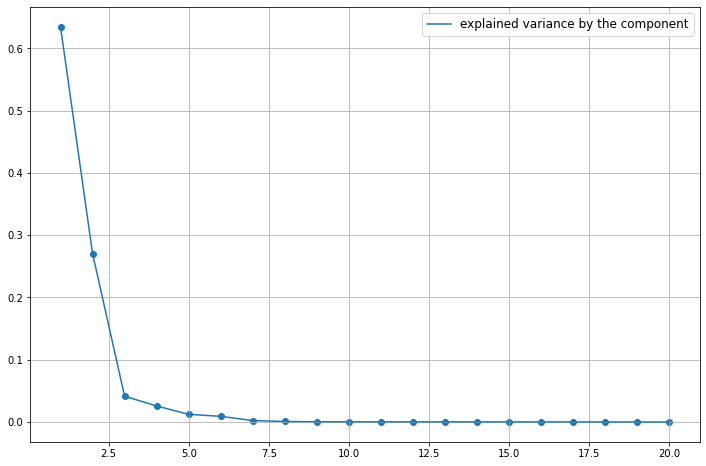

In [27]:
plt.rcParams['figure.figsize'] = (12, 8)

pca = PCA(n_components=20)
pca.fit(x_train_fnn)

plt.plot(range(1, 21), pca.explained_variance_ratio_, label='explained variance by the component')
plt.scatter(range(1, 21), pca.explained_variance_ratio_)

plt.grid()
plt.legend(fontsize=12)

As we can see, the fifth component retains almost a percentage of the variance of the original data. While the sixth is 4 times less and retains 0.2 percent of variance only. We will not take it.

In [28]:
print(f"component 5: {np.round(pca.explained_variance_ratio_[5]* 100, 3)}, " 
      f"component 6: {np.round(pca.explained_variance_ratio_[6]* 100, 3)}")

component 5: 0.915, component 6: 0.235


In [29]:
pca = PCA(n_components=5)
pca.fit(x_train_fnn)

x_train_pca = pca.transform(x_train_fnn)
x_test_pca = pca.transform(x_test_fnn)
x_valid_pca = pca.transform(x_valid_fnn)

y_train_pca = y_train_fnn.copy()
y_test_pca = y_test_fnn.copy()
y_valid_pca = y_valid_fnn.copy()

Five principal components explain 98 percent of the variance in the original data.

In [30]:
np.sum(pca.explained_variance_ratio_)

0.9847676620588585

In [31]:
def compile_pca(output_dim):
    np.random.seed(123)
    python_random.seed(123)
    tf.random.set_seed(1234)
    
    model = Sequential()

    model.add(Dense(10, activation="relu", kernel_initializer=initializers.he_normal(),
                    bias_initializer=initializers.Constant(value=0.01)))
    model.add(Dense(10, activation="relu", kernel_initializer=initializers.he_normal(),
                    bias_initializer=initializers.Constant(value=0.01)))
    model.add(Dense(10, activation="relu", kernel_initializer=initializers.he_normal(),
                    bias_initializer=initializers.Constant(value=0.01)))
    model.add(Dense(8, activation="relu", kernel_initializer=initializers.he_normal(),
                    bias_initializer=initializers.Constant(value=0.01)))
    model.add(Dense(4, activation="relu", kernel_initializer=initializers.he_normal(),
                    bias_initializer=initializers.Constant(value=0.01)))

    model.add(Dense(output_dim, name="output"))

    opt = opts.Adam(learning_rate=0.0006)
    model.compile(loss=kl.mean_absolute_error, optimizer=opt)

    return model

In [32]:
model_pca = compile_pca(output_dim=output_dim_nn)

model_pca.fit(x_train_pca, y_train_pca,
              epochs=2800, validation_data=(x_valid_pca, y_valid_pca), 
              batch_size=32, verbose=0, shuffle=True)

None

In [33]:
y_pred_t_pca = model_pca.predict(x_test_pca)
y_pred_v_pca = model_pca.predict(x_valid_pca)

y_pred_t_pca = y_pred_t_pca.reshape((y_pred_t_pca.shape[0],))
y_pred_v_pca = y_pred_v_pca.reshape((y_pred_v_pca.shape[0],))

Reducing the dimension led to a strong decrease in the architecture of the neural network, but did not lead to a significant deterioration in the model's performance.

In [34]:
metric_pca = regression_metrics("Fully connected neural network after dimension reduction", 
                                y_test_pca.copy(), y_valid_pca.copy(),
                                y_pred_t_pca.copy(), y_pred_v_pca.copy())

Method: Fully connected neural network after dimension reduction


Measure,validation data,test data
Mean absolute error,1.979,2.0
Mean relative percentage error,0.69,0.709
Coefficient of determination,0.99991,0.99991


## Сonclusions

For clarity, we will collect all the results of the used models on test data into one table. All models work with high accuracy, which is indicated by the Mean relative error and the coefficient of determination.

In [35]:
result_model = [metric_svm, metric_xgb, metric_fnn, metric_cnn, metric_pca]

tabledata = [["Mean absolute error",],
    ["Mean relative percentage error",],
    ["Coefficient of determination",]]

for i in range(len(result_model)):
    for j in range(3):
        tabledata[j] += [result_model[i][j],]

data_to_table(tabledata, columns=["Measure", "SVM", "XGB", "FCNN", "CNN", "FCNN+PCA"])

Measure,SVM,XGB,FCNN,CNN,FCNN+PCA
Mean absolute error,4.05,2.453,1.784,1.827,2.0
Mean relative percentage error,1.062,0.661,0.512,0.496,0.709
Coefficient of determination,0.9993,0.99967,0.99993,0.99992,0.99991


Additionally, we will build a correlation of the predicted label with the correct one. Since the models work in a similar way, let's build such a graph for a fully connected neural network. Additionally, we draw a straight line y = x.

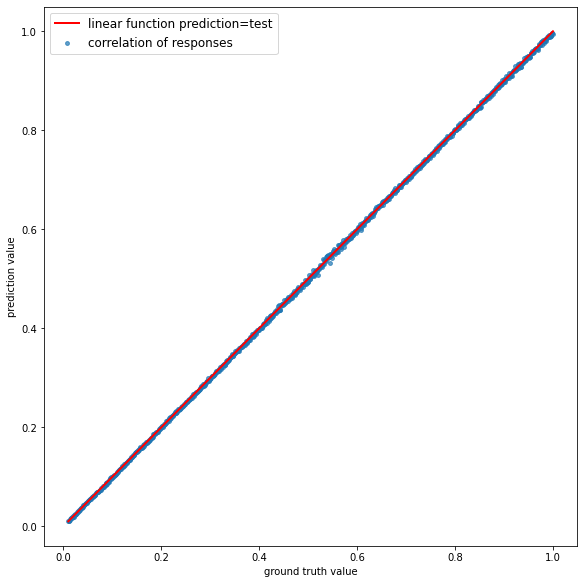

In [36]:
fig, ax = plt.subplots(figsize=(8, 8), constrained_layout=True)

plt.rc('axes', labelsize=20)
ax.set_xlabel("ground truth value")
ax.set_ylabel("prediction value")
ax.plot(y_test_fnn, y_test_fnn, color='red', label='linear function prediction=test', linewidth=2.0)
ax.scatter(y_test_fnn, y_pred_t_fnn, label='correlation of responses', alpha=0.7, s=15)

plt.legend(fontsize=12)